# 1. Install Necessary Libraries

In [70]:
%pip install -U langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph

# 2. Import necessary dependencies and set environment variables

In [71]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG

Large Language Models (LLMs) have demonstrated impressive capabilities in generating human-like text, but they are limited by the data they were trained on. This is where Retrieval Augmented Generation (RAG) comes in. RAG enhances LLMs by allowing them to access and incorporate external knowledge sources, leading to more accurate, relevant, and grounded responses. This blog post will explore the four core areas of RAG: Indexing & Embedding, Retrieval, Augmentation through Prompting, and Generation.

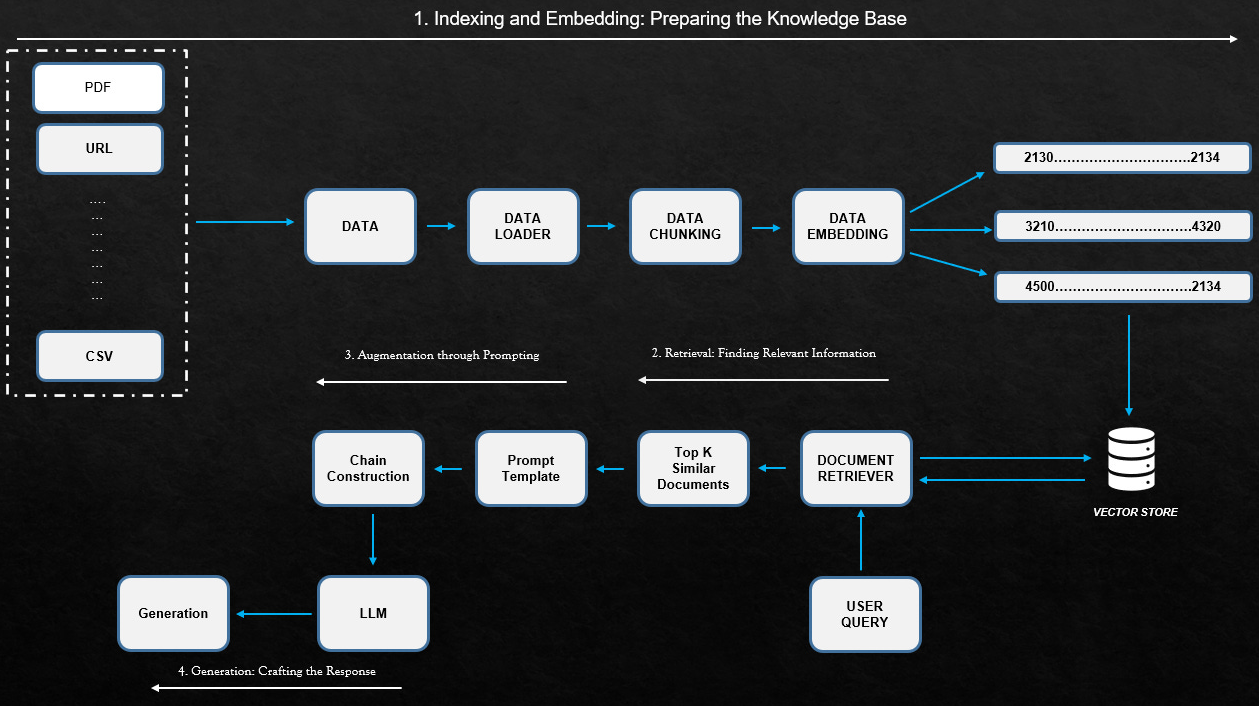

Detailed Blog :  https://aiproductplaybook.substack.com/p/2-rag-high-level-design

# 3. Self RAG

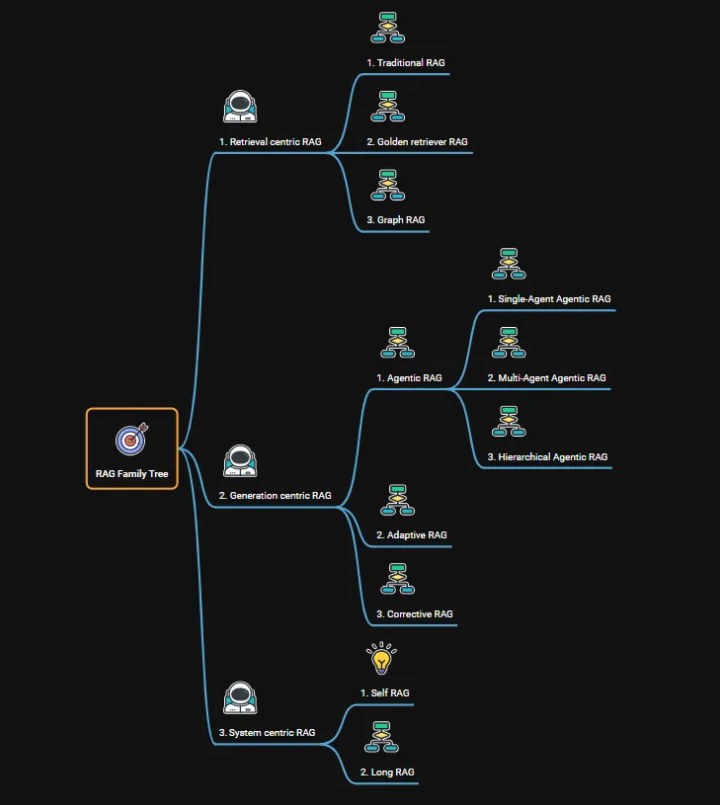

Detailed Blog : https://aiproductplaybook.substack.com/p/812-what-the-heck-are-self-rag

### a. Self RAG

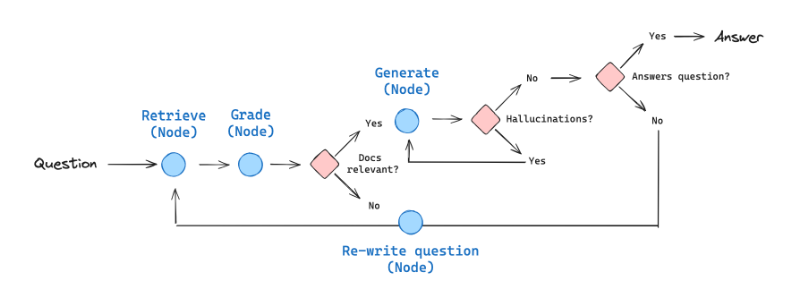

### b. Index the Knowledge Base

1. Import necessary dependencies

2. URLs : This list contains the URLs of the web pages you want to load.

3. Loading Web Pages

a. docs = [WebBaseLoader(url).load() for url in urls]: This uses a list comprehension to load the content of each URL using WebBaseLoader. The result is a list of lists, where each inner list contains the documents loaded from a single URL.

b. docs_list = [item for sublist in docs for item in sublist]: This flattens the list of lists into a single list of documents.

4. Text Splitting

a. text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(...): Creates a RecursiveCharacterTextSplitter object. This splitter recursively breaks down the text into chunks.

chunk_size=250: Specifies that each chunk should ideally be around 100 characters long.

chunk_overlap=50: Specifies that there should be a 50-character overlap between consecutive chunks. This helps preserve context across chunks.

from_tiktoken_encoder: This is an efficient way to count tokens, ensuring that chunks are split based on token count (which is more relevant for LLMs) rather than just character count. It requires the tiktoken library to be installed.

b. doc_splits = text_splitter.split_documents(docs_list): Splits the loaded documents into chunks using the configured text splitter.

5. Creating the Vector Database

a. vectorstore = Chroma.from_documents(...): Creates a Chroma vector database from the document chunks.

documents=doc_splits: Provides the list of document chunks.

collection_name="rag-chroma": Gives a name to the Chroma collection.

embedding=OpenAIEmbeddings(): Specifies that OpenAI's embeddings model should be used to create vector representations of the text chunks. This requires an OpenAI API key to be set as an environment variable (OPENAI_API_KEY).

b. retriever = vectorstore.as_retriever(): Creates a retriever object from the vector database. The retriever is used to fetch relevant chunks of text based on a query.

Summary

This code loads web pages, splits them into smaller, overlapping chunks using a tiktoken aware splitter, and then creates a Chroma vector database from these chunks.  It uses OpenAI embeddings to create vector representations of the text, which are stored in the vector database.  Finally, it creates a retriever, which can be used to efficiently retrieve relevant context from the documents based on a user's query. This setup is essential for building RAG applications, where relevant information is retrieved from a knowledge base to augment the capabilities of a large language model.

In [72]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

### c. Define the Retrieval Grader

This code defines a component for grading the relevance of a single retrieved document to a given question. It uses an LLM with structured output to get a "yes" or "no" score.  The GradeDocuments Pydantic model ensures that the LLM's output is correctly formatted.  This grader can be used to filter out irrelevant documents in a RAG pipeline, but the example code only grades one document.  In a real application, you would likely loop through all the retrieved documents and grade each one individually.

In [74]:
### Retrieval Grader


from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


### d. Define the Generate component

This code generates an answer to a question using retrieved documents and a pre-built RAG (Retrieval Augmented Generation) prompt from the LangChain Hub

How it works:

1. The rag_chain.invoke() method is called with the context and question.

2. The prompt object formats the input into the "rlm/rag-prompt" template. This template likely inserts the context and question into specific places within the prompt.

3. The formatted prompt is passed to the llm object.

4. The LLM generates a response.

5. The StrOutputParser converts the LLM's response to a string.

6. The resulting string (the answer) is returned and stored in the generation variable.

7. The answer is printed.



In [75]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Agent memory in LLM-powered autonomous systems consists of short-term and long-term memory components. Short-term memory utilizes in-context learning for immediate tasks, while long-term memory allows agents to retain and recall information over extended periods, often using external databases for storage. This memory structure enables agents to learn from past experiences and improve their interactions and decision-making.


### e. Define the Hallucination Grader

This code defines a component that uses an LLM to evaluate whether another LLM's generated answer is consistent with a set of provided facts. The use of a Pydantic model (GradeHallucinations) and with_structured_output() ensures that the LLM's response is structured and validated. This component is essential for building robust RAG systems where you need to assess the factual accuracy of the generated answers.

In [76]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

# f. Define the Answer Grader

This code defines a component that uses an LLM to evaluate whether another LLM's generated answer effectively addresses a given question. The use of a Pydantic model (GradeAnswer) and with_structured_output() ensures that the LLM's response is structured and validated. This component is useful for building QA systems where you need to assess the quality and relevance of the generated answers.

In [ ]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

### g. Define the Question Re-writer

This code defines a component that takes a user question and uses an LLM to rewrite it for better vectorstore retrieval performance. The LLM is instructed to focus on preserving the semantic meaning while making the question more suitable for querying a vector database. The use of StrOutputParser ensures that the output is a string, which is often required by vectorstore retrieval tools. The rewritten question can then be used to query the vector database, potentially leading to more relevant results.

In [77]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What are the key concepts and functionalities of agent memory in artificial intelligence?'

### g. Define the Graph states

This code defines a TypedDict called GraphState.  A TypedDict is a way to create type hints specifically for dictionaries.

The docstring ("""...""") explains the purpose of GraphState and lists its attributes:

question: str: The user's question, stored as a string.

generation: str: The LLM's generated output or answer, also stored as a string.

documents: List[str]: A list of relevant documents (or, more likely, the content of those documents as strings).

In [78]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

### h.Define the functions and logic for a Retrieval Augmented Generation (RAG) pipeline

1. retrieve(state):

Purpose: Retrieves documents based on the question.

Logic:

Prints "---RETRIEVE---".

Extracts the question from the state dictionary.

Uses a retriever object (assumed to be defined elsewhere) to fetch relevant documents.

Returns a new dictionary containing the retrieved documents and the original question.

2. generate(state):

Purpose: Generates an answer using the retrieved documents and the question.

Logic:

Prints "---GENERATE---".

Extracts the question and documents from the state.

Uses a rag_chain (a LangChain chain for RAG, assumed to be defined elsewhere) to generate the answer.

Returns a new dictionary containing the documents, question, and the generated generation.

3. grade_documents(state):

Purpose: Grades the relevance of the retrieved documents to the question.

Logic:

Prints "---CHECK DOCUMENT RELEVANCE TO QUESTION---".

Extracts question and documents from the state.

Iterates through each document:

Uses a retrieval_grader (assumed to be defined elsewhere) to score the document's relevance.

If the binary_score from the retrieval_grader is "yes":

Prints "---GRADE: DOCUMENT RELEVANT---".

Appends the document to filtered_docs.

If the binary_score is "no":

Prints "---GRADE: DOCUMENT NOT RELEVANT---".

Continues to the next document (skipping the irrelevant one).

Returns a new dictionary with the documents key updated to contain only the filtered_docs and the original question.

4. transform_query(state):

Purpose: Rewrites the question to be more effective for retrieval.

Logic:

Prints "---TRANSFORM QUERY---".

Extracts question and documents from the state.

Uses a question_rewriter (assumed to be defined elsewhere) to generate a better_question.

Returns a new dictionary with the question key updated to the better_question, and the original documents.

Edges (Functions that make decisions about the flow):

5. decide_to_generate(state):

Purpose: Determines whether to generate an answer or transform the query.

Logic:

Prints "---ASSESS GRADED DOCUMENTS---".

Extracts the question and filtered_documents (now under the documents key) from the state.

If filtered_documents is empty (no relevant documents were found):

Prints a message indicating query transformation.

Returns "transform_query" (indicating the next node to call).

Otherwise (there are relevant documents):

Prints a message indicating generation.

Returns "generate".

6. grade_generation_v_documents_and_question(state):

Purpose: Checks if the generated answer is grounded in the documents and answers the question.

Logic:

Prints "---CHECK HALLUCINATIONS---".

Extracts question, documents, and generation from the state.

Uses a hallucination_grader to check if the generation is grounded in the documents.

If the generation is grounded (grade is "yes"):

Prints "---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---".

Prints "---GRADE GENERATION vs QUESTION---".

Uses an answer_grader to check if it answers the question.

If it answers the question (grade is "yes"):

Prints "---DECISION: GENERATION ADDRESSES QUESTION---".

Returns "useful".

Else (it doesn't answer the question):

Prints "---DECISION: GENERATION DOES NOT ADDRESS QUESTION---".

Returns "not useful".

Else (the generation is not grounded):

Prints "---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---".

Returns "not supported". (This suggests a retry might happen, perhaps with a different set of documents or a different generation strategy).

summary

These functions define the steps and decision points in a RAG pipeline. The "nodes" perform actions (retrieval, generation, grading, transformation), while the "edges" (decision functions) control the flow of the graph based on the state.  This structure is typical for LangChain graphs, where these functions would be connected to define the complete RAG workflow.  The print statements are useful for debugging and understanding the flow of execution.

In [79]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

### i. Define and Visualize the Graph

In [80]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

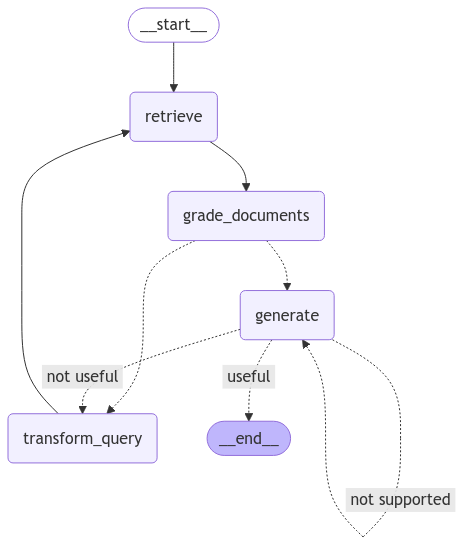

In [81]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### g. Invoke the RAG

In [82]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('The types of agent memory are short-term memory and long-term memory. '
 'Short-term memory involves in-context learning, while long-term memory '
 'allows the agent to retain and recall information over extended periods, '
 'often using an external vector store.')


In [83]:
from pprint import pprint

# Run
inputs = {"question": "Who won the Golden ball in Men's Football world cup 2022?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT R

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [60]:
from pprint import pprint

# Run
inputs = {"question": "Who won the men's singles wimbledon open 2024?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
("Carlos Alcaraz emerged victorious in the men's singles event at the 2024 "
 'Wimbledon Open, defeating Novak Djokovic with a score of 6–2, 6–2, 7–6(7–4). '
 "This victory marked Alcaraz's second Wimbledon title and his fourth major "
 'title overall.')


In [84]:
from pprint import pprint

# Run
inputs = {"question": "What are the different types of Task Decomposition?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Task decomposition can be done in three ways: (1) by using simple prompting '
 'with LLM, such as asking for steps or subgoals, (2) through task-specific '
 'instructions tailored to the task at hand, like writing a story outline, and '
 '(3) by incorporating human inputs.')


In [86]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of CoT prompts?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION DOES NOT ADDRESS QUESTION---
"Node 'generate':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION--

In [87]:
# Run
inputs = {"question": "What is Tree of Thoughts?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Tree of Thoughts is a framework that extends the Chain of Thought (CoT) '
 'approach by exploring multiple reasoning possibilities at each step. It '
 'decomposes problems into several thought steps, generating multiple thoughts '
 'for each step, which forms a tree structure. The search process can utilize '
 'either breadth-first search (BFS) or depth-first search (DFS), with each '
 'state evaluated by a classifier or through majority voting.')


In [88]:
# Run
inputs = {"question": "What does Lilian Weng say about White-box vs Black-box attacks?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Lilian Weng explains that white-box attacks allow att

In [89]:
# Run
inputs = {"question": "What is Jailbreak prompting ?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('Jailbreak prompting refers to adversarial techniques that trigger large '
 'language models (LLMs) to produce harmful content that should be restricted. '
 'These prompts are often based on heuristic and manual exploration, '
 'functioning as black-box attacks. The goal is to bypass the built-in safety '
 'mechanisms of the model.')
